In [17]:
import pandas as pd
import joblib
import numpy as np
import matplotlib.pyplot as plt

In [18]:
df = pd.read_csv("../data/EURUSD_H4_with_indicators.csv")
model = joblib.load("../models/gradient_boosting_trading_model.pkl")

model.feature_names_in_

array(['<TICKVOL>', 'atr', 'bb_bandwidth', 'bb_lower', 'bb_upper',
       'ema_50', 'macd', 'macd_diff', 'macd_signal', 'rsi', 'stoch_k'],
      dtype=object)

In [19]:
features = ['<TICKVOL>', 'atr', 'bb_bandwidth', 'bb_lower', 'bb_upper',
            'ema_50', 'macd', 'macd_diff', 'macd_signal', 'rsi', 'stoch_k']
X = df[features].dropna()

In [20]:
signals = model.predict(X)
X = X.copy()
X['signal'] = signals

In [21]:
result = df.loc[X.index, ["datetime", "<CLOSE>"]].copy()
result['signal'] = signals

In [22]:
result['return'] = np.log(result["<CLOSE>"].shift(-1) / result["<CLOSE>"])
result['strategy_return'] = 0
result.loc[result['signal'] == 'Buy', 'strategy_return'] = result['return']
result.loc[result['signal'] == 'Sell', 'strategy_return'] = -result['return']

/var/folders/3q/rggp33rx7374d1rnpz_q80nw0000gn/T/ipykernel_75182/3670490152.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.00157     0.00134263  0.00132247 ...  0.00201511 -0.00116207
  0.00125669]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  result.loc[result['signal'] == 'Buy', 'strategy_return'] = result['return']


In [23]:
result['cumulative_market'] = result['return'].cumsum()
result['cumulative_strategy'] = result['strategy_return'].cumsum()

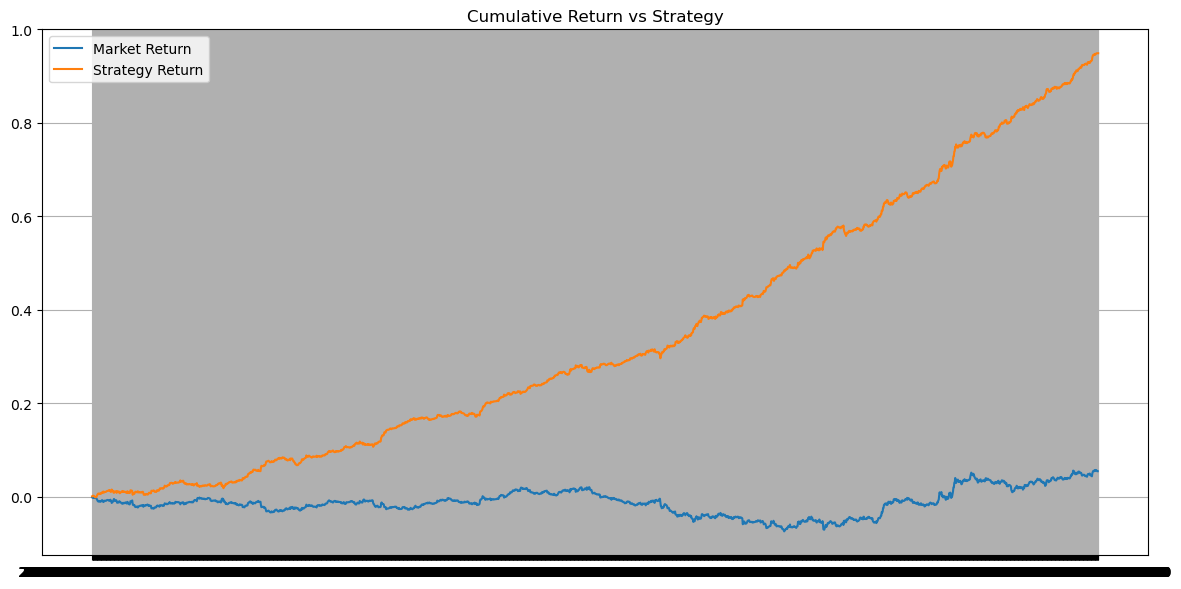

In [24]:
plt.figure(figsize=(12,6))
plt.plot(result['datetime'], result['cumulative_market'], label='Market Return')
plt.plot(result['datetime'], result['cumulative_strategy'], label='Strategy Return')
plt.legend()
plt.title("Cumulative Return vs Strategy")
plt.grid(True)
plt.tight_layout()
plt.show()

In [25]:
latest = df[features].iloc[[-1]]
if latest.isna().any().any():
    print("υπάρχουν NaN στα τελευταία δεδομένα.")
else:
    predicted_signal = model.predict(latest)[0]
    predicted_proba = model.predict_proba(latest)[0]
    label_index = list(model.classes_).index(predicted_signal)
    confidence = predicted_proba[label_index]
    print(f"\n{df['datetime'].iloc[-1]}: {predicted_signal} (confidence: {confidence:.2%})")



2025-06-25 16:00:00: Hold (confidence: 99.97%)


In [26]:
print(result['signal'].value_counts())

signal
Sell    1189
Buy     1068
Hold       3
Name: count, dtype: int64


In [27]:
print(latest.T)

for cls, prob in zip(model.classes_, predicted_proba):
    print(f"{cls}: {prob:.4f}")

                    2308
<TICKVOL>     213.000000
atr             0.003261
bb_bandwidth    1.795236
bb_lower        1.146067
bb_upper        1.166828
ema_50          1.153816
macd            0.002579
macd_diff       0.000168
macd_signal     0.002411
rsi            57.553718
stoch_k        74.560937
Buy: 0.0001
Hold: 0.9997
Sell: 0.0001
